In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn
from sklearn.cluster import KMeans

In [5]:
# --- DWBA Model for Prolate Spheroid ---
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)
    contrast = 1 / (g * h**2) + 1 / g - 2
    beta = phi[..., np.newaxis] + np.pi / 2
    aspect_ratio = L / (2 * a)
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    j1 = spherical_jn(1, bessel_arg)
    fbs = (ka**2) * L * contrast / 2 * j1 / bessel_arg
    return fbs.squeeze()

# --- Angle-independent backscatter for Sphere ---
def sphere_backscatter(L, a, g, h, ka):
    contrast = 1 / (g * h**2) + 1 / g - 2
    bessel_arg = 2 * ka / h
    j1 = spherical_jn(1, bessel_arg)
    fbs = (ka**2) * L * contrast / 2 * j1 / bessel_arg
    return fbs

In [6]:
# --- Parameters ---
a = 0.015
L = a * 6
g = 1.043
h = 1.053
c = 1500
freq = np.arange(100, 30000, 10)
ka = 2 * np.pi * freq / c * a

angle_step = 5
max_steps = 10
entropy_threshold = 0.5
codebook_size = 10

In [7]:
# --- Quantize TS spectra using k-means ---
def quantize_spectrum(spectra, kmeans=None):
    if kmeans is None:
        kmeans = KMeans(n_clusters=codebook_size, n_init=10).fit(spectra)
    labels = kmeans.predict(spectra)
    return labels, kmeans

# --- Naive emission likelihood based on distance from class mean ---
def compute_likelihood(spectrum, class_means):
    dists = [np.linalg.norm(spectrum - mean) for mean in class_means]
    log_probs = -np.array(dists)
    weights = np.exp(log_probs - np.max(log_probs))
    return weights / np.sum(weights)

In [13]:
# --- Build synthetic dataset for training codebook ---
angles_deg = np.arange(-90, 90, angle_step)

spheroid_specs = [dwba_prolate_spheroid(L, a, g, h, ka, np.deg2rad(ang)) for ang in angles_deg]
sphere_specs = [sphere_backscatter(L, a, g, h, ka) for _ in angles_deg]

spheroid_specs_db = [20 * np.log10(np.abs(fbs)) for fbs in spheroid_specs]
sphere_specs_db = [20 * np.log10(np.abs(fbs)) for fbs in sphere_specs]

all_specs = np.vstack(spheroid_specs_db + sphere_specs_db)
_, kmeans = quantize_spectrum(all_specs)

spheroid_mean = np.mean(kmeans.transform(spheroid_specs_db), axis=0)
sphere_mean = np.mean(kmeans.transform(sphere_specs_db), axis=0)
class_means = [spheroid_mean, sphere_mean]

In [16]:
true_class = 'spheroid'

In [31]:
# --- Trial Setup ---
est_class = np.random.choice(["spheroid", "sphere"])
angle = np.random.uniform(-90, 90)

(-100.0, 0.0)

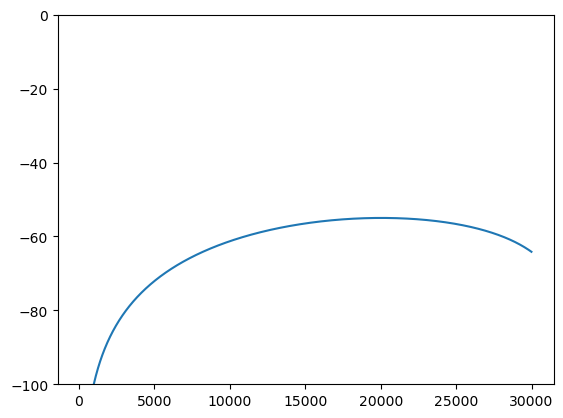

In [32]:
angles_visited = []
probs_history = []

step = 0
phi = np.deg2rad(angle)

if true_class == "spheroid":
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
else:
    fbs = sphere_backscatter(L, a, g, h, ka)

spectrum_db = 20 * np.log10(np.abs(fbs))
plt.plot(freq, spectrum_db)
plt.ylim(-100, 0)

In [35]:
vec = kmeans.transform(spectrum_db.reshape(1, -1))[0]
vec

array([146.11757227, 929.800323  , 596.4259809 , 872.29035046,
       991.72144021, 294.10503878, 637.50647177, 545.39284824,
       819.60940576, 907.51352589])

In [ ]:
probs = compute_likelihood(vec, class_means)
entropy = -np.sum(probs * np.log(probs + 1e-12))

angles_visited.append(angle)
probs_history.append(probs)

if entropy < entropy_threshold:
    print(entropy)
    break

# Evaluate next angles
def future_entropy(theta):
    phi = np.deg2rad(theta)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi) if true_class == "spheroid" else sphere_backscatter(L, a, g, h, ka)
    spec_db = 20 * np.log10(np.abs(fbs))
    vec = kmeans.transform(spec_db.reshape(1, -1))[0]
    p = compute_likelihood(vec, class_means)
    return -np.sum(p * np.log(p + 1e-12))

cw = angle + angle_step
ccw = angle - angle_step
angle = cw if future_entropy(cw) < future_entropy(ccw) else ccw

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(len(angles_visited)), angles_visited, marker='o')
ax.set_xlabel("Step")
ax.set_ylabel("Incident Angle (deg)")
ax.set_title(f"Decision trajectory (true class: {true_class})")
ax.grid(True)
plt.tight_layout()
plt.show()
